# MNIST Dataset
This notebook builds a CNN model to predict the famous MNIST digits dataset -https://www.kaggle.com/c/digit-recognizer/ 


Check out:

1. https://www.tensorflow.org/tutorials/generative/style_transfer

2. https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization 
# Load Data



In [ ]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
assert sys.version_info >= (3, 6) # Python ≥3.6 is required
import tensorflow as tf
assert tf.__version__ > "2.0" #  check version
from tensorflow import keras

In [ ]:
# load data from kaggle
raw_train_data = pd.read_csv('./train.csv')
raw_test_data = pd.read_csv('./test.csv')
raw_train_data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# split training data into X and y
y_train_full = raw_train_data.label.values
X_train_full = raw_train_data.drop(columns=['label'])

Create a function to preprocess the data. 

In [ ]:
def preprocess(raw_data):
  """
  Function to turn raw data into preprocessed data.
  """
  # scale data to 0 to 1
  raw_data = raw_data.values / 255. # turn into numpy array

  reshaped_data = raw_data.reshape([-1, 28, 28]) #  reshape array
  
  # tensorflow accepts a 4D matrix only
  # i.e. since the MNIST is grey-scale only it has 1 channel
  return reshaped_data[..., np.newaxis]

X_test = preprocess(raw_test_data)
X_train_full_processed = preprocess(X_train_full)
X_train_full_processed.shape # shape of entire training set, includes validation set

(42000, 28, 28, 1)

# Explore Data

By now you probably know a lot about the MNIST Digit Recognizer dataset, I would suggest checking out the kaggle link if you do not. Because of this, we will skip this step of data science project and go right to preparing the data. 

# Prepare the Data 

In [ ]:
# split into train, validation and test sets
X_train, X_valid = X_train_full_processed[5000:], X_train_full_processed[-5000:]
y_train, y_valid = y_train_full[5000:], y_train_full[-5000:]

In [ ]:
print('Training data shape' , X_train.shape) # shape of training data has been reduced
print('Validation data shape' , X_valid.shape)

Training data shape (37000, 28, 28, 1)
Validation data shape (5000, 28, 28, 1)


# Build Convolutional Neural Network Model 

The model being built contains a preprocessing layer, where each batch during training undergoes minor data augmentation. We have to be careful not to 'over' augment the data, where a 9 turns into a 6 for example.

We are using a CNN which has the following layers (from input to output):

1. Apply minor Data Augmentation using Tensorflow
2. 2x Convolutional with 32 filters and 64 filters respectively, followed by a MaxPoolingLayer
3. Residual Unit followed by a Global Average pooling layer
4. Flatten Layer with dropout

5. Dense Layer with Dropout and Batch Normalization 
6. Output dense layer using `dense=10` and `activation='softmax'`

In [ ]:
# set random seed
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
data_augmentation = keras.models.Sequential([
        keras.layers.experimental.preprocessing.RandomRotation(
            factor=0.05, fill_mode='constant'),
        keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.4, fill_mode='constant'),
        keras.layers.experimental.preprocessing.RandomTranslation(
            height_factor=0.3,
            width_factor=0.3,
            fill_mode='constant')
])

Plot data augmentation.

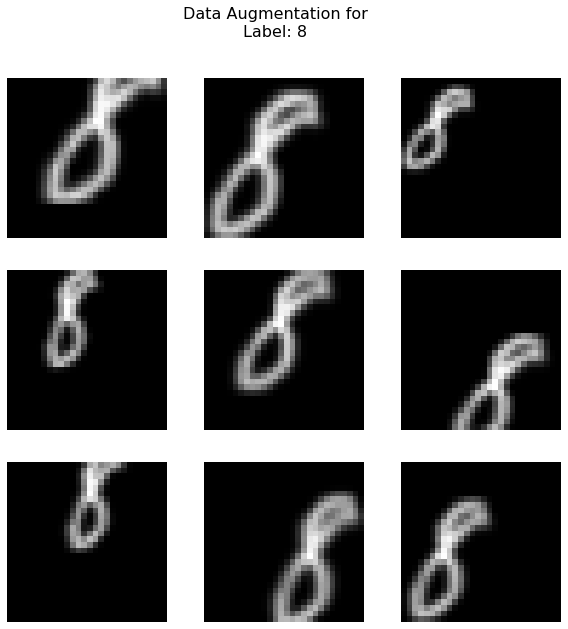

In [ ]:
# Add the image to a batch
image = tf.expand_dims(X_train[0, :, :, :], 0)

fig = plt.figure(figsize=(10, 10))
fig.suptitle(f"Data Augmentation for\nLabel: {y_train[0]}", fontsize=16)
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0, :, :, 0], cmap='gray')
  plt.axis("off")

plt.show()

In [ ]:
DefaultConv = partial(keras.layers.Conv2D,
                      kernel_size=3,
                      strides=1,
                      padding='SAME')

In [ ]:
class ResidualUnit(keras.layers.Layer):

  """
  Class that creates a residual unit.
  """
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
      super().__init__(**kwargs)
      self.activation = keras.activations.get(activation)
      self.main_layers = [
          DefaultConv(filters=filters, strides=strides, use_bias=False),
          keras.layers.BatchNormalization(),
          self.activation,
          DefaultConv(filters=filters, use_bias=False),
          keras.layers.BatchNormalization()]
      self.skip_layers = []
      if strides > 1:
          self.skip_layers = [
              DefaultConv(filters=filters, kernel_size=1, strides=strides, use_bias=False),
              keras.layers.BatchNormalization()]

  def call(self, inputs):
      Z = inputs
      for layer in self.main_layers:
          Z = layer(Z)
      skip_Z = inputs
      for layer in self.skip_layers:
          skip_Z = layer(skip_Z)
      return self.activation(Z + skip_Z)

In [ ]:
rest_of_model = keras.models.Sequential([
              DefaultConv(filters=32, activation='relu'),
              DefaultConv(filters=64, activation='relu'),
              keras.layers.MaxPool2D(),
              ResidualUnit(filters=64),
              ResidualUnit(filters=64),
              ResidualUnit(filters=128, strides=2),
              ResidualUnit(filters=128, strides=2),
              keras.layers.Flatten(),
              keras.layers.Dropout(0.25),
              keras.layers.Dense(128, activation='relu'),
              keras.layers.BatchNormalization(),
              keras.layers.Dropout(0.5),
              keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# combine data augmentation and rest of the model 
input_shape = (28, 28, 1)
classes = 10

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
outputs = rest_of_model(x)
model = keras.Model(inputs, outputs)

In [ ]:
# compile model based on categorical cross entropy
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [ ]:
# define early callback
callbacks = keras.callbacks.EarlyStopping(patience=10)

# train model 
model.fit(X_train, y_train,
          epochs=50,
          validation_data=(X_valid, y_valid),
          callbacks=[callbacks])

Epoch 1/50
1157/1157 [==============================] - 76s 60ms/step - loss: 0.7648 - accuracy: 0.7647 - val_loss: 0.4080 - val_accuracy: 0.8796
Epoch 2/50
1157/1157 [==============================] - 69s 60ms/step - loss: 0.2188 - accuracy: 0.9358 - val_loss: 1.5156 - val_accuracy: 0.6842
Epoch 3/50
1157/1157 [==============================] - 69s 60ms/step - loss: 0.1723 - accuracy: 0.9502 - val_loss: 0.1115 - val_accuracy: 0.9670
Epoch 4/50
1157/1157 [==============================] - 69s 60ms/step - loss: 0.1492 - accuracy: 0.9573 - val_loss: 0.1162 - val_accuracy: 0.9676
Epoch 5/50
1157/1157 [==============================] - 69s 60ms/step - loss: 0.1386 - accuracy: 0.9606 - val_loss: 0.1043 - val_accuracy: 0.9656
Epoch 6/50
1157/1157 [==============================] - 69s 60ms/step - loss: 0.1246 - accuracy: 0.9651 - val_loss: 0.1813 - val_accuracy: 0.9550
Epoch 7/50
1157/1157 [==============================] - 69s 60ms/step - loss: 0.1160 - accuracy: 0.9662 - val_loss: 0.0812 -

# Evaluate on Test Data

In [ ]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 2s 10ms/step - loss: 0.0359 - accuracy: 0.9906


[0.03588945418596268, 0.9905999898910522]

The model would be considered within the top 15% on Kaggle without using the test set to aid with training - as explained on https://www.kaggle.com/c/digit-recognizer/discussion/61480



# Save prediction for submission to Kaggle


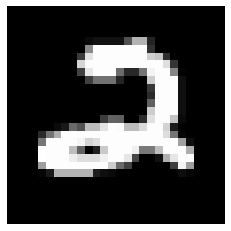

array([2])

In [ ]:
# plot 'i'th value within the test dataset 
i = 0
# plot 'i'th value within test data
plt.imshow(X_test[i, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

# print model prediction 
np.argmax(model.predict(tf.expand_dims(X_test[i], 0)), axis=1)

In [ ]:
# SUBMIT TO KAGGLE
results = model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("./MNIST-CNN.csv",index=False)